# Flow sensing Neural Network

### Importing Libraries and Packages

In [1]:
import pandas as pd
import numpy as np
from numpy import linalg 
from matplotlib import cm
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D,Conv1D, MaxPooling2D,MaxPooling1D, UpSampling2D, UpSampling1D, Conv2DTranspose,Conv1DTranspose
from keras.models import Model
from keras.preprocessing import image
%matplotlib inline
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from keras import layers
from keras.layers import LeakyReLU
from keras.layers import TimeDistributed
import math
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [15]:
# Used to clear the pressure data file and save copies of it a temporary folder so that the main data files do not get affected 
#Used only once 
import os

for i in range(0,5500):
    f = open("C:/Users/DELL/Desktop/lily-pad/Saved_Files/pressure{}.txt".format(i),"r")
    g = open ("C:/Users/DELL/Desktop/lily-pad/TRIAL/temp1.txt","x")
    lines = f.readlines()
    f.close()
    
    for line in lines:
        if not (line.startswith('%')):
            g.write(line)
        
    g.close()
    os.rename("C:/Users/DELL/Desktop/lily-pad/TRIAL/temp1.txt","C:/Users/DELL/Desktop/lily-pad/TRIAL/pressure{}.txt".format(i))

### Defining Variables Used later in the Code

In [2]:
df = pd.DataFrame()
counter = []
c =0 
skip = []
t = list(range(0, 197))

### SVD Calculation for Each DataSet / Simulation

In [3]:
for i in range(0,5500):
    
# Importing Datasets and Preprocessing
    z = pd.read_csv("C:/Users/DELL/Desktop/lily-pad/TRIAL/pressure{}.txt".format(i),header = None , delimiter = ' ')  #Type the value of File name of be plotted 
    z.drop(z.tail(0).index,inplace=True,axis=0) 
    z = z.add_prefix('Pressure_')
    del z["Pressure_201"]
    z = z.rename({'Pressure_0': 'Time_Step'}, axis='columns')
    z = z.dropna()
    z = z.drop(columns = ['Time_Step'])
    Z = z.to_numpy()
    Z= Z.T
# SVD for each Dataset    
    Z = StandardScaler().fit_transform(Z)
    U , S , VT = np.linalg.svd(Z,full_matrices=0)
# Removing Error / Junk Data     
    if len(S) < 50:
        skip.append(i)
        continue
    l = 0
    count = 0
    a = pd.DataFrame(S).sum(axis = 0, skipna = True).to_numpy()
# Choosing the number of Datasets with the eigen energy amounting to 98% for each file
    for j in range(len(S)):
        l += S[j]
        if l/a <= .98:
            count += 1
    counter.append(count)
    df[i] = S[:50]
    c=c+1
df = df.T
df.reset_index(inplace = True, drop = True)

In [5]:
df.shape

(5499, 50)

In [6]:
skip

[2372]

### Importing the Output values for the Model i.e Distances/Position

In [23]:
a_Values = pd.read_csv("C:/Users/DELL/Desktop/lily-pad/randomization.csv", header = None)
a_Values = a_Values.add_prefix('a_')
a_Values = a_Values.loc[0: , :  ] 
a_Values = a_Values.dropna()
#values = a_Values.loc[0:5]

# Choosing the pertinent Datasets 
values = a_Values.drop(columns=['a_4'])
#Removing the Junk DataFiles
final_values = values.drop(skip)
final_values.reset_index(inplace = True, drop = True)


In [25]:
final_values.shape

(5499, 5)

### Finding the Ideal Number of Eigen Values using Mean / Std 

In [26]:
#plt.scatter(t,counter)
Description = pd.DataFrame(counter).describe()
components = Description.loc['mean'] + 2 * Description.loc['std']  
components = math.ceil(components)
components

22

In [27]:
from sklearn.preprocessing import StandardScaler
x_std = StandardScaler().fit_transform(df)
x_std = x_std[:,:components]

### Calcualtion PCA/POD

In [28]:
from sklearn import decomposition 
pca = decomposition.PCA(n_components = components)
sklearn_pca_x = pca.fit_transform(x_std)
sklearn_result = pd.DataFrame(sklearn_pca_x)

### Training the Model 

In [29]:
X_train = np.asarray(sklearn_result.loc[:5000])
Y_train = np.asarray(final_values.loc[:5000])

X_Validation = np.asarray(sklearn_result.loc[5001:5250])
Y_Validation = np.asarray(final_values.loc[5001:5250])

X_test = np.asarray(sklearn_result.loc[5251:])
Y_test = np.asarray(final_values.loc[5251:])

In [30]:
input_layer = keras.Input(shape=(components), name="INPUT")
hidden_layer_1 = layers.Dense(256, activation='relu', name="HIDDEN_1")(input_layer)
code_layer = layers.Dense(256, activation='relu', name="CODE")(hidden_layer_1)
output_layer = layers.Dense(5, activation='relu', name="OUTPUT")(code_layer)

In [31]:
AE = Model(input_layer, output_layer)
AE.compile(optimizer='adam', loss='mean_squared_error')
AE.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 22)]              0         
_________________________________________________________________
HIDDEN_1 (Dense)             (None, 256)               5888      
_________________________________________________________________
CODE (Dense)                 (None, 256)               65792     
_________________________________________________________________
OUTPUT (Dense)               (None, 5)                 1285      
Total params: 72,965
Trainable params: 72,965
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = AE.fit(X_train, Y_train, epochs=100 , batch_size= 10, validation_data= (X_Validation,Y_Validation))

Epoch 1/100
501/501 [==============================] - 2s 3ms/step - loss: 0.3989 - val_loss: 0.3418
Epoch 2/100
501/501 [==============================] - 1s 2ms/step - loss: 0.3348 - val_loss: 0.3128
Epoch 3/100
501/501 [==============================] - 1s 2ms/step - loss: 0.3165 - val_loss: 0.3012
Epoch 4/100
501/501 [==============================] - 1s 2ms/step - loss: 0.3065 - val_loss: 0.2905
Epoch 5/100
501/501 [==============================] - 1s 2ms/step - loss: 0.3002 - val_loss: 0.2833
Epoch 6/100
501/501 [==============================] - 1s 3ms/step - loss: 0.2950 - val_loss: 0.2812
Epoch 7/100
501/501 [==============================] - 1s 2ms/step - loss: 0.2918 - val_loss: 0.2727
Epoch 8/100
501/501 [==============================] - 1s 2ms/step - loss: 0.2870 - val_loss: 0.2797
Epoch 9/100
501/501 [==============================] - 1s 2ms/step - loss: 0.2851 - val_loss: 0.2693
Epoch 10/100
501/501 [==============================] - 1s 2ms/step - loss: 0.2814 - val_lo

501/501 [==============================] - 1s 2ms/step - loss: 0.1287 - val_loss: 0.1855
Epoch 82/100
501/501 [==============================] - 1s 2ms/step - loss: 0.1286 - val_loss: 0.1934
Epoch 83/100
501/501 [==============================] - 1s 2ms/step - loss: 0.1268 - val_loss: 0.1942
Epoch 84/100
501/501 [==============================] - 1s 2ms/step - loss: 0.1281 - val_loss: 0.1895
Epoch 85/100
501/501 [==============================] - 1s 2ms/step - loss: 0.1261 - val_loss: 0.1838
Epoch 86/100
501/501 [==============================] - 1s 2ms/step - loss: 0.1269 - val_loss: 0.1973
Epoch 87/100
501/501 [==============================] - 1s 2ms/step - loss: 0.1265 - val_loss: 0.1900
Epoch 88/100
501/501 [==============================] - 1s 2ms/step - loss: 0.1251 - val_loss: 0.1895
Epoch 89/100
501/501 [==============================] - 1s 2ms/step - loss: 0.1251 - val_loss: 0.1944
Epoch 90/100
501/501 [==============================] - 1s 2ms/step - loss: 0.1240 - val_loss: 

In [33]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


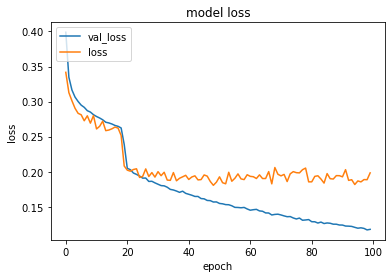

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val_loss', 'loss'], loc='upper left')
#plt.savefig('Loss_Plot.png',dpi=300)
plt.show()

### Predicting Using the Trained Model 

In [217]:
test.loc[20]

a_0    0.763705
a_1    0.162162
a_2    2.781452
a_3    0.782328
a_5    0.000000
Name: 20, dtype: float64

In [218]:
sample.loc[20]

0    0.953305
1    0.477658
2    1.372075
3    0.882479
4    0.700021
Name: 20, dtype: float32

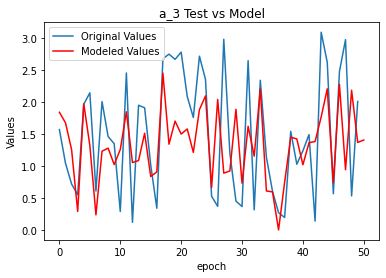

In [42]:
decoded_data = AE.predict(X_test)
dl = pd.DataFrame(decoded_data)
# Taking the first 50 trained datasets for the graph
sample = dl.loc[:50]
sample.reset_index(inplace = True, drop = True)
# Taking the corresponding 50 datasets of the training
test = final_values.iloc[5251:5301]
test.reset_index(inplace = True, drop = True)

# Plotting the results for a_0,a_1,a_2,a_3

plt.plot(test['a_2'])
plt.plot(sample[2],'red')
# plt.scatter(5,1.146255,color='green')
# plt.scatter(20,0.782328,color='green')
# plt.scatter(30,0.843887,color='green')
# plt.scatter(39,0.813857,color='green')
plt.title('a_3 Test vs Model')
plt.ylabel('Values')
plt.xlabel('epoch')
plt.legend(['Original Values','Modeled Values'], loc='upper left')
#plt.savefig('a_3 Test VS Model.png',dpi=300)
plt.show()


### Predicting the a_5 ( i.e Object Detection)

In [38]:
mid = pd.DataFrame(dl[4]).describe()
fd = pd.DataFrame()
fd[1]=1
for i in range(0,248):
    if dl[4].iloc[i] <= (mid.loc['mean'].values):
        fd.loc[i] = 0
    else:
        fd.loc[i] = 1 
a1 = final_values.iloc[5251:]
aa = a1['a_5']
aa.reset_index(inplace = True, drop = True)   

In [39]:
# Accuracy for Predicting Whether the object is Ellipse or Rectangle 
a=0
for i in range(0,248):
    if fd.iloc[i].values == aa[i]:
        a = a+1
accuracy = a/len(aa) * 100
print(str(accuracy) + " %")

72.58064516129032 %


## Plotting the modes for a simulation

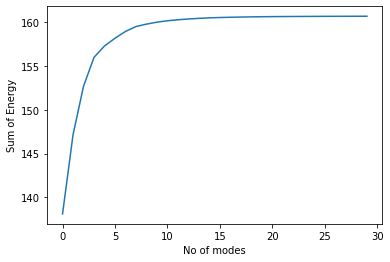

In [43]:
mode =[]
l = 0
for i in range(0,len(S)):
    l = l + S[i]
    mode.append(l)

plt.plot(mode[:30])
#plt.title('Mode for SVD')
plt.ylabel('Sum of Energy')
plt.xlabel('No of modes')
#plt.savefig('SVD_Mode_Plot.png',dpi=300)
plt.show()

In [44]:
mid.loc['mean'].values

array([0.45315188])

In [236]:
dl.to_excel("output.xlsx")